In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csv_file = "single_thread_thp.csv"

# read data and group by key_path, index_type, init_table_size, test_suite
df = pd.read_csv(csv_file)

# group by as key_path index_type init_table_size test_suite
df_grouped = df.groupby(["key_path", "index_type", "init_table_size", "test_suite"])

# construct a new dataframe for each group
df_new = pd.DataFrame(
    columns=[
        "key_path",
        "index_type",
        "init_table_size",
        "test_suite",
        "insert_throughput_avg",
        "insert_throughput_min",
        "insert_throughput_max",
        "insert_throughput_stdv",
        "insert_throughput_cv",
        "read_throughput_avg",
        "read_throughput_min",
        "read_throughput_max",
        "read_throughput_stdv",
        "read_throughput_cv",
        "memory_consumption",
    ]
)
for name, group in df_grouped:
    key_path, index_type, init_table_size, test_suite = name
    insert_throughput_avg = group.loc[group["insert_ratio"] == 1, "throughput"].mean()/ 1000000
    insert_throughput_min = group.loc[group["insert_ratio"] == 1, "throughput"].min()
    insert_throughput_max = group.loc[group["insert_ratio"] == 1, "throughput"].max()
    insert_throughput_stdv = group.loc[group["insert_ratio"] == 1, "throughput"].std()
    insert_throughput_cv = insert_throughput_stdv / insert_throughput_avg
    read_throughput_avg = group.loc[group["insert_ratio"] == 0, "throughput"].mean()/ 1000000
    read_throughput_min = group.loc[group["insert_ratio"] == 0, "throughput"].min()
    read_throughput_max = group.loc[group["insert_ratio"] == 0, "throughput"].max()
    read_throughput_stdv = group.loc[group["insert_ratio"] == 0, "throughput"].std()
    read_throughput_cv = read_throughput_stdv / read_throughput_avg
    memory_consumption = group["memory_consumption"].mean()
    df_new.loc[len(df_new)] = [
        key_path,
        index_type,
        init_table_size,
        test_suite,
        insert_throughput_avg,
        insert_throughput_min,
        insert_throughput_max,
        insert_throughput_stdv,
        insert_throughput_cv,
        read_throughput_avg,
        read_throughput_min,
        read_throughput_max,
        read_throughput_stdv,
        read_throughput_cv,
        memory_consumption,
    ]

In [2]:
sorted_insert_suites = [21, 31, 41, 51, 61, 71, 81, 91, 101, 111]

random_insert_suites = [22, 32, 42, 52, 62, 72, 82, 92, 102, 112]

bulk_load_whole_data_suites = 10

uniform_sampling_suites = [21, 22]

interval_sampling_suites = [31, 32, 33, 34, 35]

substring_sampling_suites = [41, 42, 51, 52, 61, 62, 71, 72]

zipfian_sampling_suites = [81, 82, 91, 92, 101, 102]

normal_sampling_suites = [111, 112]

pgm_sampling_suites = []

overall_test_suites = (
    uniform_sampling_suites + substring_sampling_suites + [bulk_load_whole_data_suites]
)

gap_size = 0.08

index_types = ["btree", "art", "alex", "lipp", "dytis", "dili"]

index_type_to_num = {type_: i for i, type_ in enumerate(index_types)}

plt.rcParams.update({"font.size": 13})

index_colors = {
    "btree": "#4e7a96",
    "art": "#b5ceb2",
    "alex": "LightBlue",
    "lipp": "LightCoral",
    "dytis": "#9467bd",
    "dili": "#fee08b",
}

index_markers = {
    "btree": "o",
    "art": "d",
    "alex": "x",
    "lipp": "1",
    "dytis": "+",
    "dili": "*",
}

df_new = df_new[df_new["test_suite"].isin(overall_test_suites)]


def get_official_name(str):
    if str == "btree":
        return "B+tree"
    elif str == "art":
        return "ART"
    elif str == "alex":
        return "ALEX"
    elif str == "lipp":
        return "LIPP"
    elif str == "dytis":
        return "DyTIS"
    elif str == "dili":
        return "DILI"
    elif str == "datasets/linear":
        return "Linear"
    elif str == "datasets/covid":
        return "Covid"
    elif str == "datasets/fb":
        return "Face"
    elif str == "datasets/fb-1":
        return "Face"
    elif str == "datasets/osm":
        return "OSM"

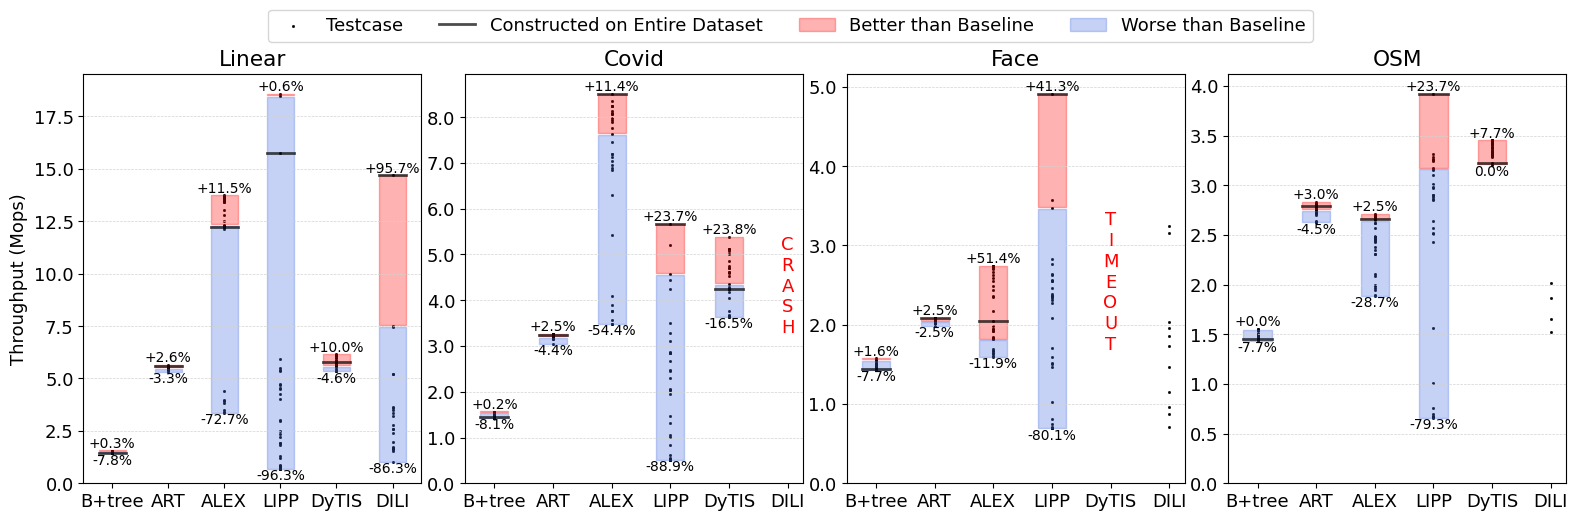

In [12]:
# figure: Overall Result
def get_scatter_style_final(row):
    """
    Determines the style for scatter plots based on the row data.

    Parameters:
    - row: DataFrame row containing the data for a particular data point.

    Returns:
    - color: Color of the scatter plot marker.
    - marker: Style of the marker.
    - linestyle: Style of the line.
    - label: Label for the legend.
    - size: Size of the marker.
    - offset: Offset for the marker position.
    """
    color = "black"
    edgecolor = "black"
    marker = "."
    size = 10
    linestyle = "-"
    linewidth = 0.5
    label = "Testcase"
    offset = 0

    return color, edgecolor, marker, linestyle, linewidth, label, size, offset


datasets = ["datasets/linear", "datasets/covid", "datasets/fb-1", "datasets/osm"]
fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharey=False)

for i in range(len(datasets)):
    dataset = datasets[i]
    df_dataset = df_new[df_new["key_path"] == dataset]

    baseline = df_dataset[
        (df_dataset["test_suite"] == 22) & (df_dataset["init_table_size"] == 100000000)
    ]
    #
    read_optimal = df_dataset[df_dataset["test_suite"] == bulk_load_whole_data_suites]
    read_throughput_bounds = df_dataset.groupby("index_type")[
        "read_throughput_avg"
    ].agg(["min", "max"])

    axs[i].set_title(get_official_name(dataset))

    if i == 0:
        axs[i].set_ylabel("Throughput (Mops)")

    axs[i].yaxis.grid(which="both", linestyle="--", linewidth=0.5, color="lightgrey")
    axs[i].set_ylim(bottom=0, top=df_dataset["read_throughput_avg"].max() * 1.05)

    axs[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}"))  # type: ignore

    index_types = ["btree", "art", "alex", "lipp", "dytis", "dili"]
    index_type_to_num = {type_: i for i, type_ in enumerate(index_types)}
    for j in range(len(index_types)):
        axs[i].scatter(
            index_type_to_num[index_types[j]],
            0,
            color="white",
            linestyle="--",
            linewidth=0.01,
        )

    axs[i].set_xticks(range(len(index_types)))
    axs[i].set_xticklabels([get_official_name(index) for index in index_types])
    # read throughput scatter plot
    for j, row in df_dataset.iterrows():
        (
            color,
            edgecolor,
            marker,
            linestyle,
            linewidth,
            label,
            size,
            offset,
        ) = get_scatter_style_final(row)
        axs[i].scatter(
            index_type_to_num[row["index_type"]] + offset,
            row["read_throughput_avg"],
            color=color,
            edgecolor=edgecolor,
            label=label,
            s=size,
            marker=marker,
            linestyle=linestyle,
            linewidth=linewidth,
        )

    # read baseline
    for j in range(len(baseline)):
        baseline_throughput = baseline["read_throughput_avg"].values[j]
        optimal_throuput = read_optimal["read_throughput_avg"].values[j]
        axs[i].plot(
            [
                index_type_to_num[baseline["index_type"].values[j]] - gap_size * 3,
                index_type_to_num[baseline["index_type"].values[j]] + gap_size * 3,
            ],
            [optimal_throuput, optimal_throuput],
            label="Constructed on Entire Dataset",
            color="black",
            linestyle="-",
            linewidth=2,
            alpha=0.7,
        )

    # Add shaded area to scatterplot to indicate throughput bounds
    j = 0
    for _, (index_type, bounds) in enumerate(read_throughput_bounds.iterrows()):
        if baseline["index_type"].values[j] != index_type:
            continue
        baseline_throughput = baseline["read_throughput_avg"].values[j]
        # Fill area if upper bound exceeds baseline
        if bounds["max"] > baseline_throughput:
            axs[i].fill_between(
                [
                    index_type_to_num[baseline["index_type"].values[j]] - gap_size * 3,
                    index_type_to_num[baseline["index_type"].values[j]] + gap_size * 3,
                ],
                baseline_throughput+axs[i].get_ylim()[1]*0.0022,
                bounds["max"],
                label="Better than Baseline",
                color="Red",
                alpha=0.3,
            )
            positive_percentage = (
                (bounds["max"] - baseline_throughput) / baseline_throughput * 100
            )
            axs[i].text(
                index_type_to_num[baseline["index_type"].values[j]],
                bounds["max"],
                f"+{positive_percentage:.1f}%",
                ha="center",
                va="bottom",
                size=10,
            )
        else:
            positive_percentage = 0.0
            axs[i].text(
                index_type_to_num[baseline["index_type"].values[j]],
                bounds["max"],
                f"+{positive_percentage:.1f}%",
                ha="center",
                va="bottom",
                size=10,
            )

        # Fill area if lower bound falls below baseline
        if bounds["min"] < baseline_throughput:
            axs[i].fill_between(
                [
                    index_type_to_num[baseline["index_type"].values[j]] - gap_size * 3,
                    index_type_to_num[baseline["index_type"].values[j]] + gap_size * 3,
                ],
                bounds["min"],
                baseline_throughput-axs[i].get_ylim()[1]*0.0022,
                label="Worse than Baseline",
                color="RoyalBlue",
                alpha=0.3,
            )
            negative_percentage = (
                (bounds["min"] - baseline_throughput) / baseline_throughput * 100
            )
            axs[i].text(
                index_type_to_num[baseline["index_type"].values[j]],
                bounds["min"],
                f"{negative_percentage:.1f}%",
                ha="center",
                va="top",
                size=10,
            )
        else:
            negative_percentage = 0.0
            axs[i].text(
                index_type_to_num[baseline["index_type"].values[j]],
                bounds["min"],
                f"{negative_percentage:.1f}%",
                ha="center",
                va="top",
                size=10,
            )
        j = j + 1

    # dili crash
    if datasets[i] == "datasets/covid":
        axs[i].text(
            5,
            axs[i].get_ylim()[1] / 1.65,
            "C\nR\nA\nS\nH",
            ha="center",
            va="top",
            color="red",
        )

    # dytis oom
    if datasets[i] == "datasets/fb-1":
        axs[i].text(
            4,
            axs[i].get_ylim()[1] / 1.5,
            "T\nI\nM\nE\nO\nU\nT",
            ha="center",
            va="top",
            color="red",
        )

# Create legend with unique labels
handles, labels = fig.gca().get_legend_handles_labels()
unique_labels = {}
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels[label] = handle

fig.legend(
    unique_labels.values(),
    unique_labels.keys(),
    loc="upper center",
    bbox_to_anchor=(0.5, 1.06),
    ncol=5,
)
plt.tight_layout(w_pad=0.01)
plt.show()
# export pdf
fig.savefig("./fig/single_thread_overall.pdf", bbox_inches="tight", transparent=True)

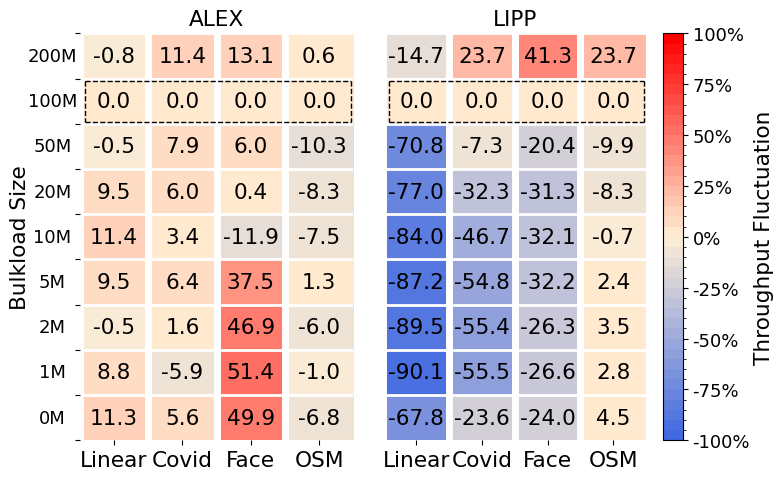

In [13]:
# figure: Impact of Bulkload Size
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

indexes = ["alex", "lipp"]
datasets = ["datasets/linear", "datasets/covid", "datasets/fb-1", "datasets/osm"]
df_workload = df_new[
    (df_new["test_suite"] == 22) | (df_new["test_suite"] == bulk_load_whole_data_suites)
]

fig, axs = plt.subplots(1, 2, figsize=(8, 5), width_ratios=[5, 6])

cmap = mcolors.LinearSegmentedColormap.from_list(
    "red_to_green", ["RoyalBlue", "PapayaWhip", "Red"]
)
bounds = np.linspace(-100, 100, 41)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for i, index_type in enumerate(indexes):
    df_index = df_workload[df_workload["index_type"] == index_type].copy(True)
    for j, dataset in enumerate(datasets):
        mask = df_index["key_path"] == dataset
        baseline_throughput = df_index[
            mask & (df_index["init_table_size"] == 100000000)
        ]["read_throughput_avg"].values[0]
        # copy a new column for percentage fluctuation
        df_index.loc[mask, "read_throughput_avg_tmp"] = (
            (df_index.loc[mask, "read_throughput_avg"] - baseline_throughput)
            / baseline_throughput
            * 100
        )

    pivot_df = df_index.pivot(
        index="init_table_size", columns="key_path", values="read_throughput_avg_tmp"
    )
    cols = list(pivot_df.columns)
    cols[0], cols[1], cols[2], cols[3] = cols[2], cols[0], cols[1], cols[3]
    pivot_df = pivot_df[cols]
    pivot_df = pivot_df.iloc[::-1]

    cax = axs[i].imshow(pivot_df, cmap=cmap, norm=norm, aspect="auto")
    # turn off outside grid
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)

    # Add gridlines
    for (k, j), val in np.ndenumerate(pivot_df):
        col_line = plt.Rectangle(
            [j - 0.5, k - 0.5], 0, 1, fill=False, edgecolor="white", linewidth=5
        )
        axs[i].add_patch(col_line)
        if np.isnan(val):
            axs[i].text(
                j, k, "OOM", ha="center", va="center", color="black", size="large"
            )
        else:
            axs[i].text(
                j,
                k,
                f"{val:.1f}",
                ha="center",
                va="center",
                color="black",
                size="large",
            )

        row_line = plt.Rectangle(
            [j - 0.5, k - 0.5], 1, 0, fill=False, edgecolor="white", linewidth=2
        )
        axs[i].add_patch(row_line)

    # mark out the baseline
    axs[i].plot([-0.42, 3.47], [0.55, 0.55], color="black", linestyle="--", linewidth=1)
    axs[i].plot(
        [-0.42, -0.42], [0.55, 1.45], color="black", linestyle="--", linewidth=1
    )
    axs[i].plot([-0.42, 3.47], [1.45, 1.45], color="black", linestyle="--", linewidth=1)
    axs[i].plot([3.47, 3.47], [0.55, 1.45], color="black", linestyle="--", linewidth=1)

    if i == len(indexes) - 1:
        plt.colorbar(cax, ax=axs[i], format="%d%%")
        axs[i].text(
            5.3,
            4,
            "Throughput Fluctuation",
            ha="center",
            va="center",
            color="black",
            rotation=90,
            size="large",
        )
    
    axs[i].set_title(f"{get_official_name(index_type)}")
    axs[i].set_xlabel("")
    axs[i].set_xticks(range(len(datasets)))
    axs[i].set_xticklabels(["Linear", "Covid", "Face", "OSM"], rotation=0, size="large")

    if i == 0:
        axs[i].set_ylabel("Bulkload Size", size="large")
        axs[i].set_yticks(np.arange(-0.5, len(pivot_df.index) + 0.5, 1))
        axs[i].set_yticklabels(
            ["      ", "      ", "      ", "      ", "      ", "      ", "      ", "      ", "      ", "      "]
        )
        for j in range(len(pivot_df.index)):
            axs[i].text(
                -0.9,
                j,
                f"{pivot_df.index[j] // 1000000}M",
                ha="center",
                va="center",
                color="black",
            )
    else:
        axs[i].set_yticks([])

plt.tight_layout(w_pad=1.5)
plt.show()

fig.savefig("./fig/single_thread_impact_of_bulkload_size.pdf", bbox_inches="tight", transparent=True)

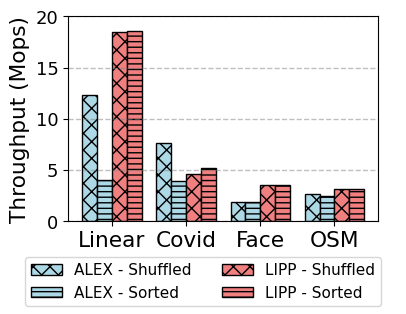

In [36]:
# figure: Impact of Insert Pattern
index_types = ["alex", "lipp"]
index_type_to_num = {type_: i for i, type_ in enumerate(index_types)}
datasets = ["datasets/linear", "datasets/covid", "datasets/fb-1", "datasets/osm"]
df_workload = df_new[
    ((df_new["test_suite"] == 21) | (df_new["test_suite"] == 22))
    & (df_new["init_table_size"] == 100000000)
]

fig = plt.figure(figsize=(4, 3.355))

plt.ylabel("Throughput (Mops)", size="large")
plt.ylim(0, 20)
plt.gca().yaxis.grid(
    which="major", linestyle="--", linewidth=1, color="gray", alpha=0.5
)
plt.xticks(
    range(len(datasets)),
    [get_official_name(dataset) for dataset in datasets],
    size="large",
)


for i, dataset in enumerate(datasets):
    df_dataset = df_workload[df_workload["key_path"] == dataset]

    for j, index_type in enumerate(index_types):
        df_index = df_dataset[df_dataset["index_type"] == index_type]
        color = index_colors[index_type]
        sorted_throughput = df_index[df_index["test_suite"] == 21][
            "read_throughput_avg"
        ].values[0]
        shuffled_throughput = df_index[df_index["test_suite"] == 22][
            "read_throughput_avg"
        ].values[0]
        plt.bar(
            i + j * 0.4 - 0.3,
            shuffled_throughput,
            color=color,
            width=0.2,
            edgecolor="black",
            label=f"{get_official_name(index_type)} - Shuffled",
            hatch="xx",
        )
        plt.bar(
            i + j * 0.4 + 0.2 - 0.3,
            sorted_throughput,
            color=color,
            width=0.2,
            edgecolor="black",
            label=f"{get_official_name(index_type)} - Sorted",
            hatch="---",
        )

# Create legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = {}
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels[label] = handle

fig.subplots_adjust(bottom=0.27)
fig.legend(unique_labels.values(), unique_labels.keys(), loc="lower center", ncol=2,fontsize=11)

# plt.tight_layout()
plt.show()
fig.savefig("./fig/single_thread_impact_of_insert_pattern.pdf", bbox_inches="tight", transparent=True)


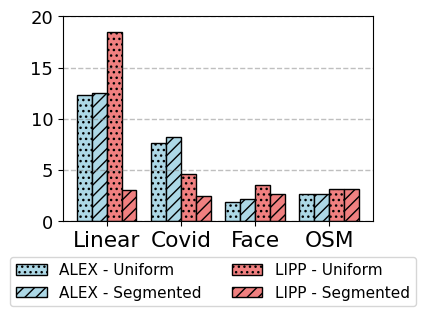

In [39]:
# figure: Impact of Sampling Method
index_types = ["alex", "lipp"]
index_type_to_num = {type_: i for i, type_ in enumerate(index_types)}
datasets = ["datasets/linear", "datasets/covid", "datasets/fb-1", "datasets/osm"]
df_workload = df_new[
    ((df_new["test_suite"] == 22) | (df_new["test_suite"] == 42))
    & (df_new["init_table_size"] == 100000000)
]

fig = plt.figure(figsize=(4, 3.355))

plt.ylim(0, 20)
plt.gca().yaxis.grid(
    which="major", linestyle="--", linewidth=1, color="gray", alpha=0.5
)
plt.xticks(
    range(len(datasets)),
    [get_official_name(dataset) for dataset in datasets],
    size="large",
)

for i, dataset in enumerate(datasets):
    df_dataset = df_workload[df_workload["key_path"] == dataset]

    for j, index_type in enumerate(index_types):
        df_index = df_dataset[df_dataset["index_type"] == index_type]
        color = index_colors[index_type]
        uniform_throughput = df_index[df_index["test_suite"] == 22][
            "read_throughput_avg"
        ].values[0]
        substring_throughput = df_index[df_index["test_suite"] == 42][
            "read_throughput_avg"
        ].values[0]
        # zipfian_throughput = df_index[df_index["test_suite"] == 82][
        #     "read_throughput_avg"
        # ].values[0]
        plt.bar(
            i + j * 0.4 - 0.3,
            uniform_throughput,
            color=color,
            width=0.2,
            edgecolor="black",
            label=f"{get_official_name(index_type)} - Uniform",
            hatch="...",
        )
        plt.bar(
            i + j * 0.4 + 0.2 - 0.3,
            substring_throughput,
            color=color,
            width=0.2,
            edgecolor="black",
            label=f"{get_official_name(index_type)} - Segmented",
            hatch="///",
        )
        # plt.bar(
        #     i + j * 0.4 + 0.4 - 0.3,
        #     zipfian_throughput,
        #     color=color,
        #     width=0.2,
        #     edgecolor="black",
        #     label=f"{get_official_name(index_type)} - Zipfian",
        #     hatch="xxx",
        # )
# Create legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = {}
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels[label] = handle

fig.subplots_adjust(bottom=0.27)
fig.legend(unique_labels.values(), unique_labels.keys(), loc="lower center", ncol=2,fontsize=11)

# plt.tight_layout()
plt.show()
fig.savefig("./fig/single_thread_impact_of_sampling_method.pdf", bbox_inches="tight", transparent=True)


In [ ]:
# table: Failed Case
import pandas as pd
import re
from collections import defaultdict

# 读取日志文件
with open('single_thread_fail_case.log', 'r') as file:
    log_lines = file.readlines()

# 初始化数据结构
fail_data = defaultdict(lambda: defaultdict(int))

# 解析日志文件
for line in log_lines:
    index_match = re.search(r'Failed command: .* --index=(\w+)', line)
    test_suite_match = re.search(r'--test_suite=(\d+)', line)
    if index_match and test_suite_match:
        index = index_match.group(1)
        test_suite = test_suite_match.group(1)
        if 'Subprocess timeout' in line:
            reason = 'timeout'
        elif 'Subprocess failed with error code -11' in line:
            reason = 'error_code -11'
        elif 'Subprocess failed with error code -9' in line:
            reason = 'error_code -9'
        else:
            reason = 'other'
        fail_data[index]['failed'] += 1
        fail_data[index][reason] += 1
# 转换为Pandas DataFrame
data = []
for index, reasons in fail_data.items():
    fail_data[index]['total'] = 4
    row = {'index': index, 'total': reasons['total']}
    row.update(reasons)
    data.append(row)

df = pd.DataFrame(data)
df = df.fillna(0)  # 填充NaN值为0

# 打印结果
print(df)

In [17]:
# table: Worst Insert Result
# for all index_type, get the minimum insert throughput
df_insert_worst = df_new.groupby(["index_type", "key_path"])[
    "insert_throughput_avg"
].min()
df_insert_worst = df_insert_worst.reset_index()
df_insert_worst = df_insert_worst.sort_values(
    by=["key_path", "insert_throughput_avg"], ascending=[True, True]
)

pivot_df = df_insert_worst.pivot_table(
    index="key_path",
    columns="index_type",
    values="insert_throughput_avg"
)
print(pivot_df)

index_type           alex       art     btree      dili     dytis      lipp
key_path                                                                   
datasets/covid   2.105405  2.600645  1.315640       NaN  1.347297  0.341343
datasets/fb-1    0.984533  2.197458  1.314032  0.831612       NaN  0.425393
datasets/linear  2.734329  4.600589  1.316275  0.184134  0.625265  0.468523
datasets/osm     1.222404  2.422300  1.316693  1.124640  0.141842  0.407422
